# 📝 Introduction

We are **Team Two**:  
- **Wong Li Xiang**  
- **Kavin Gnanasageran**  
*(ECSE students from Monash University)*  

## 🎯 Theme
Our project is part of the competition under the theme:  
**CommentSense – Measure content effectiveness by analyzing comment quality & relevance at scale.**

## 📚 About This Notebook
This notebook contains the **entire workflow**, including:  
1. **Loading raw data** (comments + videos).  
2. **Filtering and preprocessing** (spam removal, categorization).  
3. **Analysis using pretrained Transformers** (sentiment analysis + relevancy scoring).  
4. **Optional blocks** (e.g., data saving, visualizations) that may be skipped if not needed.  
5. **Final interactive block**: a standalone module that runs once the required output datasets from sentiment and relevancy analysis have been generated.  

👉 The notebook is designed to be **modular and flexible**, so users can run the full pipeline or skip optional parts depending on their goals.  


---

## 📚 Libraries Import

This block imports all the required Python libraries.  

⚠️ **Note:**  
If you encounter an `ModuleNotFoundError` while running this block, install the missing library using the command below (replace `package-name` with the actual library name):

```bash
!pip install package-name


In [1]:
## Library import
import torch
import os
import glob
import pandas as pd
import re
import numpy as np
import isodate
import matplotlib.pyplot as plt
import seaborn as sns
from torch.utils.data import DataLoader, Dataset
from transformers import AutoTokenizer, AutoModelForSequenceClassification
from tqdm import tqdm
import time
from scipy.special import softmax
import emoji
from time import perf_counter
from sentence_transformers import SentenceTransformer
import ast
from IPython.display import display, clear_output
import ipywidgets as widgets

def format_time(seconds):
    """Convert seconds to HH:MM:SS string."""
    h = int(seconds // 3600)
    m = int((seconds % 3600) // 60)
    s = int(seconds % 60)
    return f"{h:02d}:{m:02d}:{s:02d}"


ModuleNotFoundError: No module named 'isodate'

## 📂 Data Loading

In this section, two types of datasets are used:  

- **Comment Data** → named `comments1` to `comments5`  
- **Video Data** → named `videos`  

✅ Make sure all related data files are saved in the **same directory** as this Jupyter notebook, under the folder path defined as `DATA_DIR`.


In [ ]:
## Data loading
DATA_DIR=r"C:\Users\lixia\Downloads\LOrealCompPrototype\LOrealCompPrototype"

#comment data
commentData = glob.glob(os.path.join(DATA_DIR, "comments[1-5].csv"))
commentData.sort()
df_comments = pd.concat([pd.read_csv(f) for f in commentData], ignore_index=True)
print("Merged shape Comment Data:", df_comments.shape)
print(df_comments.columns.tolist())

#video data
df_video = pd.read_csv(os.path.join(DATA_DIR, "videos.csv"))
print("Merged shape Video Data:", df_video.shape)
print(df_video.columns.tolist())


Merged shape Comment Data: (4725012, 10)
['kind', 'commentId', 'channelId', 'videoId', 'authorId', 'textOriginal', 'parentCommentId', 'likeCount', 'publishedAt', 'updatedAt']
Merged shape Video Data: (92759, 15)
['kind', 'videoId', 'publishedAt', 'channelId', 'title', 'description', 'tags', 'defaultLanguage', 'defaultAudioLanguage', 'contentDuration', 'viewCount', 'likeCount', 'favouriteCount', 'commentCount', 'topicCategories']


## 🚫 Spam Filtering

This section classifies and filters out **spam comments** based on a set of rules:

1. Comments containing **links**  
2. **Short comments** (less than 5 words)  
3. Comments made up mostly of **symbols**  
4. Comments with a **majority of uppercase letters** (e.g., angry shouting)

Additionally, it also removes other unwanted patterns, such as:

- **Duplicate comments**: the same exact comment posted by the same user across different videos  

✅ The **filtered dataset** will be displayed in the output cell for inspection.


In [ ]:
# -----------------------------
# Define the updated spam rule
# -----------------------------
def is_spam_text(text):
    if pd.isna(text) or len(str(text).strip()) == 0:
        return True  # empty comment

    text = str(text)
    text_lower = text.lower()

    # Rule 1: Contains links
    if "http" in text_lower or "www." in text_lower or ".com" in text_lower:
        return True

    # Rule 2: Very short comments only
    if len(text) < 6:
        return True

    # Rule 3: Majority symbols/emojis
    total_chars = len(text)
    if total_chars > 0:
        symbol_count = len(re.findall(r'[^\w\s]', text))
        emoji_count = len(emoji.emoji_list(text))
        if (symbol_count + emoji_count) / total_chars > 0.5:
            return True

    # Rule 4: Majority uppercase letters
    letters_only = re.sub(r'[^A-Za-z]', '', text)
    if len(letters_only) > 0:
        upper_count = sum(1 for c in letters_only if c.isupper())
        if upper_count / len(letters_only) > 0.5:
            return True

    return False

# -----------------------------
# Flag repeated comments across videos
# -----------------------------
# Count how many times each author-text pair appears
dup_counts = df_comments.groupby(['authorId','textOriginal'], observed=False).size().reset_index(name='count')

# Get set of repeated comments
repeated_set = set(
    tuple(x) for x in dup_counts[dup_counts['count'] > 1][['authorId','textOriginal']].values
)

# -----------------------------
# Apply spam rules (vectorized)
# -----------------------------
# Flag spam comments
df_comments['spam_rule'] = df_comments['textOriginal'].apply(is_spam_text)

# Flag repeated comments
df_comments['repeated_across_videos'] = df_comments.apply(
    lambda row: (row['authorId'], row['textOriginal']) in repeated_set, axis=1
)

# -----------------------------
# Combine all spam flags into one unified column
# -----------------------------
df_comments['is_spam'] = df_comments['spam_rule'] | df_comments['repeated_across_videos']

# -----------------------------
# Save clean and spam comments separately
# -----------------------------
clean_comments = df_comments[~df_comments['is_spam']].copy()
spam_comments = df_comments[df_comments['is_spam']].copy()

# -----------------------------
# Adjust comment counts per video
# -----------------------------
# Count how many spam comments per video
spam_per_video = spam_comments.groupby('videoId').size().reset_index(name='spam_count')

# Merge with video dataset (assuming it's called df_videos with ['videoId','commentCount'])
df_video = df_video.merge(spam_per_video, on='videoId', how='left')

# Fill missing spam_count with 0 (for videos with no spam detected)
df_video['spam_count'] = df_video['spam_count'].fillna(0).astype(int)

# Compute adjusted comment count
df_video['AdjCommentCount'] = df_video['commentCount'] - df_video['spam_count']

# -----------------------------
# Step 7: Save adjusted video data
# -----------------------------
df_video.to_csv("adjusted_videos.csv", index=False)
print("Adjusted video data saved to adjusted_videos.csv")


# -----------------------------
# Summary
# -----------------------------
print(f"Total comments: {len(df_comments)}")
print(f"Spam comments: {len(spam_comments)} saved to spam_comments.csv")
print(f"Clean comments: {len(clean_comments)} saved to clean_comments.csv")

# -----------------------------
# Optional: Display examples
# -----------------------------
print("\n=== Example Spam Comments ===")
print(spam_comments[['authorId','textOriginal']].head(10).to_string(index=False))

print("\n=== Example Clean Comments ===")
print(clean_comments[['authorId','textOriginal']].head(10).to_string(index=False))


Adjusted video data saved to adjusted_videos.csv
Total comments: 4725012
Spam comments: 1061537 saved to spam_comments.csv
Clean comments: 3663475 saved to clean_comments.csv

=== Example Spam Comments ===
 authorId                                        textOriginal
  2032536 PLEASE LESBIAN FLAG I BEG YOU \n\nYou would rock it
  1853470                                                Baaa
  2775194                                          ❤❤❤❤❤❤❤❤❤❤
  3158722                                                   ❤
   785546                                                Love
  2502640                            RadheKrishna🙏🙏🌸🌸❤❤😍😍🧿🧿🥰🥰
  3610950                              💞💞💞💞💞💞💞💞💞🙏🙏🙏🙏🙏🙏🙏🙏👍👍👍👍👍
  3415783                                ❤️❤️❤️❤️❤️❤️❤️❤️❤️❤️
  2575009                                          Love u❤️❤️
   894013                                    You’re welcome 😊

=== Example Clean Comments ===
 authorId                                           textOriginal
  3043229      

## 🏷️ Video Categorisation

This section categorises videos into topics (**skincare, makeup, fashion, etc.**) by scanning the **title, description, and tags**.  
It checks if certain **keywords or patterns** exist in the text, without considering frequency or position.

### 🔑 How it works
- **Keyword sets** → `CATEGORY_KEYWORDS`, `SAFE_SUFFIXES` define what to look for.  
- **Regex patterns** are built to match:
  - **Hashtags** → `#skincare`, `#makeupreview`  
  - **Glued forms** → `makeuptutorial`, `skincareroutine`  
  - **Whole words** → `lipstick`, `serum`  

### ⚙️ Process
1. Merge all text for each video (title + description + tags)  
2. Apply regex patterns  
3. Store all matching categories  
   - First match → `primary_category`  
   - Other matches → `categories`  

👉 **Method used:** *rule-based regex text classification* (not machine learning).  


In [ ]:
##VIDEO CATEGORISATION
CATEGORY_KEYWORDS = {
    "skincare": [
        "skincare", "skin care", "cleanser", "face wash", "toner", "serum",
        "essence", "ampoule", "moisturiser", "moisturizer", "cream", "lotion",
        "sunscreen", "sun screen", "sunblock", "spf", "retinol", "vitamin c",
        "niacinamide", "hyaluronic", "aha", "bha", "salicylic", "exfoliant",
        "mask", "sheet mask", "skin", "aging", "young", "old", "scrub"
    ],
    "selfcare": [
        "selfcare", "self care", "self", "care", "wellness", "relax",
        "meditation", "spa", "pamper"
    ],
    "makeup": [
        "makeup", "make up", "foundation", "concealer", "cushion", "bb cream",
        "cc cream", "powder", "blush", "bronzer", "highlighter", "contour",
        "lipstick", "lip gloss", "lip tint", "mascara", "eyeliner", "brow",
        "eyeshadow", "palette", "primer", "setting spray", "beauty",
        "makeuptutorial"
    ],
    "haircare": [
        "hair", "haircare", "hair care", "shampoo", "conditioner", "hair mask",
        "leave-in", "hair oil", "serum hair", "anti-frizz", "anti frizz",
        "heat protectant", "tonic", "scalp", "dandruff", "wig", "haircut",
        "hairdo", "hair makeover", "alopecia", "hairstyle", "hairloss"
    ],
    "bodycare": [
        "body care", "bodycare", "body lotion", "body cream", "body wash",
        "shower gel", "body scrub", "hand cream", "body butter", "body"
    ],
    "fashion": [
        "fashion", "style", "aesthetic", "trend", "outfit", "clothing", "clothes",
        "wardrobe", "attire", "look", "ootd", "runway", "couture", "designer",
        "streetwear", "vintage", "chic", "glam", "apparel", "dress", "suit",
        "casualwear", "formalwear", "menswear", "womenswear", "accessories",
        "bag", "handbag", "purse", "shoes", "sneakers", "heels", "boots",
        "hat", "cap", "jacket", "coat", "scarf", "jeans", "t-shirt", "skirt",
        "blouse", "saree", "kimono", "hanbok", "abaya", "model", "fashionista",
        "fit check", "drip", "swag", "stylish"
    ]
}
SAFE_SUFFIXES = [
        "tutorial", "tutorials", "routine", "routines",
        "tip", "tips", "trick", "tricks", "hack", "hacks",
        "review", "reviews", "haul", "look", "looks",
        "challenge", "challenges", "set", "sets", "kit", "kits",
        "101", "guide", "ideas", "style", "styles","shorts"
    ]
def _compile_category_patterns(cat_keywords, safe_suffixes):
    """
    Build case-insensitive patterns that match whole words, hashtags, and
    glued suffixes (e.g., 'makeuptutorial'), with optional simple plural 's'.
    """
    suffix_alt = "(?:" + "|".join(map(re.escape, safe_suffixes)) + ")"
    patterns = {}
    for cat, kws in cat_keywords.items():
        escaped = []
        for k in kws:
            k = k.strip().lower()
            if not k:
                continue
            # Allow optional trailing 's' to match simple plurals
            escaped.append(f"{re.escape(k)}s?")
        if not escaped:
            continue
        base = "(?:" + "|".join(escaped) + ")"
        # Match as:
        # 1) hashtags like #skincare, #spf50, #lipstickreview, #makeuptutorials
        hashtag_part = rf"#(?:{base})(?:{suffix_alt})?[A-Za-z0-9_]*"
        # 2) glued with safe suffixes (e.g., 'makeup' + 'tutorial' → 'makeuptutorial')
        glued_part   = rf"(?<![A-Za-z0-9_])(?:{base})(?:{suffix_alt})(?![A-Za-z0-9_])"
        # 3) whole words (no alnum on either side)
        word_part    = rf"(?<!\w){base}(?!\w)"

        pat = re.compile(rf"(?:{hashtag_part}|{glued_part}|{word_part})", re.IGNORECASE)
        patterns[cat] = pat

    return patterns
def _uniq_preserve_order(xs):
    seen = set()
    out = []
    for x in xs:
        if x not in seen:
            seen.add(x)
            out.append(x)
    return out
def detect_categories_regex(text, patterns):
    t = (text or "")
    hits = [cat for cat, pat in patterns.items() if pat.search(t)]
    return _uniq_preserve_order(hits)

for col in ["title", "description", "tags"]:
    if col not in df_video.columns:
        df_video[col] = ""
df_video[["title", "description", "tags"]] = df_video[["title", "description", "tags"]].fillna("") ##fill in missiong values with ""

##Concatenating, title, desciption and tags columns into new column.
df_video["video_text"] = (
    (df_video["title"] + " " + df_video["description"] + " " + df_video["tags"])
    .str.replace(r"\s+", " ", regex=True)
    .str.strip()
)

# ----------  Categorising videos ---------- #
CATEGORY_PATTERNS = _compile_category_patterns(CATEGORY_KEYWORDS, SAFE_SUFFIXES)
# --- categorize each video ---
df_video["categories"] = df_video["video_text"].apply(lambda t: detect_categories_regex(t, CATEGORY_PATTERNS))
df_video["primary_category"] = df_video["categories"].apply(lambda xs: xs[0] if xs else "uncategorized")

#quick checks
print(df_video[["videoId", "primary_category", "categories"]].head())
print(df_video["primary_category"].value_counts(dropna=False))

#save
df_video.to_csv("videos_categorised_trail.csv", index=False)


   videoId primary_category         categories
0    85806         skincare         [skincare]
1    30556         skincare         [skincare]
2    51771           makeup  [makeup, fashion]
3    45298    uncategorized                 []
4    43611           makeup           [makeup]
primary_category
makeup           29004
skincare         27510
haircare         18592
uncategorized     9904
selfcare          3533
fashion           3170
bodycare          1046
Name: count, dtype: int64


## 📊 Strength of Engagement (SoE) Metric

This section calculates the **Strength of Engagement (SoE)**, a metric that measures how engaging a video is, relative to its **duration** and **views**.  

### 🎬 Duration Buckets
To ensure fairness (so short videos with quick bursts of engagement don’t dominate), videos are grouped into three buckets:
- **Short** → `0s – 1min`  
- **Medium** → `1min – 10min`  
- **Long** → `10min+`  

### 🧮 SoE Formula
The SoE score is defined as a **weighted combination of engagement signals**:

\[
\text{SoE} = \alpha \times \text{likes} \;+\; \beta \times \text{favourites} \;+\; \gamma \times \text{comments}
\]

Where:  
- **α, β, γ** = weighting factors (tunable hyperparameters)  
- Each engagement type contributes differently to the overall score  

👉 By bucketing videos by duration, the SoE avoids bias toward only **short, viral-style clips** and provides a fairer comparison across video types.  


In [ ]:
# Step 1: Convert ISO8601 duration → seconds (vectorized via list comprehension)
# Step 1a: Handle NaN / missing durations
def parse_duration_safe(x):
    if pd.isna(x):
        return 0  # or some default, e.g., 0 seconds
    try:
        return isodate.parse_duration(x).total_seconds()
    except:
        return 0  # fallback if parsing fails

df_video["duration_seconds"] = np.array([parse_duration_safe(x) for x in df_video["contentDuration"]])


# Step 2: Assign duration buckets (vectorized using pd.cut)
bins = [0, 60, 600, np.inf]  # seconds
labels = ["Short", "Medium", "Long"]
df_video["duration_bucket"] = pd.cut(df_video["duration_seconds"], bins=bins, labels=labels, right=True)

# Step 3: Compute Adjusted Views
df_video["duration_safe"] = df_video["duration_seconds"].replace(0, 1)  # avoid divide by zero
df_video["AdjViews"] = df_video["viewCount"].clip(lower=10) / np.log1p(df_video["duration_safe"] + 1)

# Step 4: Compute weighted engagement (generic scale: comment>favourite>likes)
weights = np.array([1, 2, 3])  # likes, favourites, comments
df_video["weighted_engagement"] = df_video["likeCount"] * weights[0] + df_video["favouriteCount"] * weights[1] + df_video["AdjCommentCount"] * weights[2]

# Step 5: Compute SoE
df_video["SoE"] = df_video["weighted_engagement"] #/ df_video["AdjViews"]

# Optional: keep only necessary columns for analysis
df_result = df_video[["videoId", "duration_bucket", "duration_seconds", "viewCount", "AdjViews",
                "likeCount", "favouriteCount", "commentCount", "weighted_engagement", "SoE"]]

# Check results
print(df_video.columns.tolist())




['kind', 'videoId', 'publishedAt', 'channelId', 'title', 'description', 'tags', 'defaultLanguage', 'defaultAudioLanguage', 'contentDuration', 'viewCount', 'likeCount', 'favouriteCount', 'commentCount', 'topicCategories', 'spam_count', 'AdjCommentCount', 'video_text', 'categories', 'primary_category', 'duration_seconds', 'duration_bucket', 'duration_safe', 'AdjViews', 'weighted_engagement', 'SoE']


# 💾 Optional: Data Saving

👉 This step is **optional** — skip if you prefer to keep results only in memory during exploration.  

In [ ]:
# Iterate over each duration bucket and save as separate CSV
for bucket in df_video["duration_bucket"].unique():
    if pd.isna(bucket):
        continue  # skip NaN buckets
    df_bucket = df_video[df_video["duration_bucket"] == bucket].copy()

    # File name includes bucket name
    file_name = os.path.join(DATA_DIR, f"videos_{bucket}.csv")
    df_bucket.to_csv(file_name, index=False)

    print(f"Saved {len(df_bucket)} videos to {file_name}")

Saved 81214 videos to C:\Users\lixia\Downloads\LOrealCompPrototype\LOrealCompPrototype\videos_Short.csv
Saved 8031 videos to C:\Users\lixia\Downloads\LOrealCompPrototype\LOrealCompPrototype\videos_Medium.csv
Saved 2247 videos to C:\Users\lixia\Downloads\LOrealCompPrototype\LOrealCompPrototype\videos_Long.csv


# 📊 Optional: SoE Spread Visualization

👉 This step is **optional** — meant for **exploration and diagnostics**, not required for the main pipeline.  

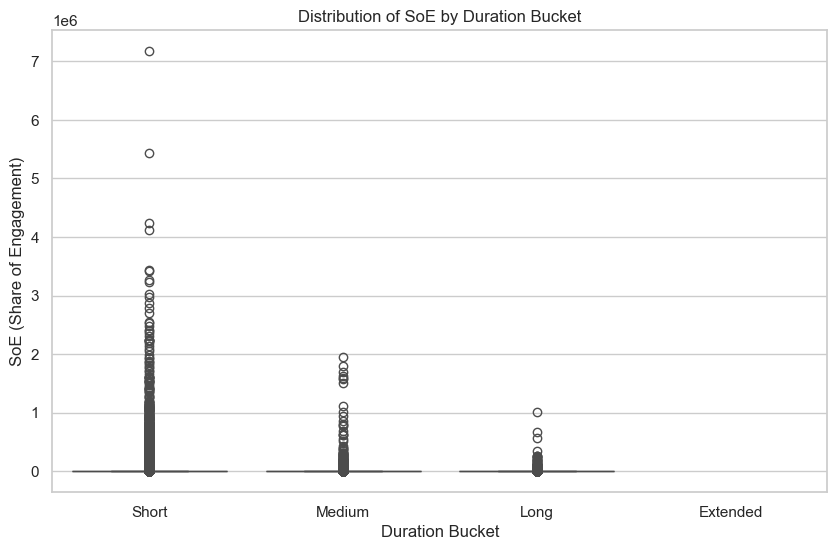

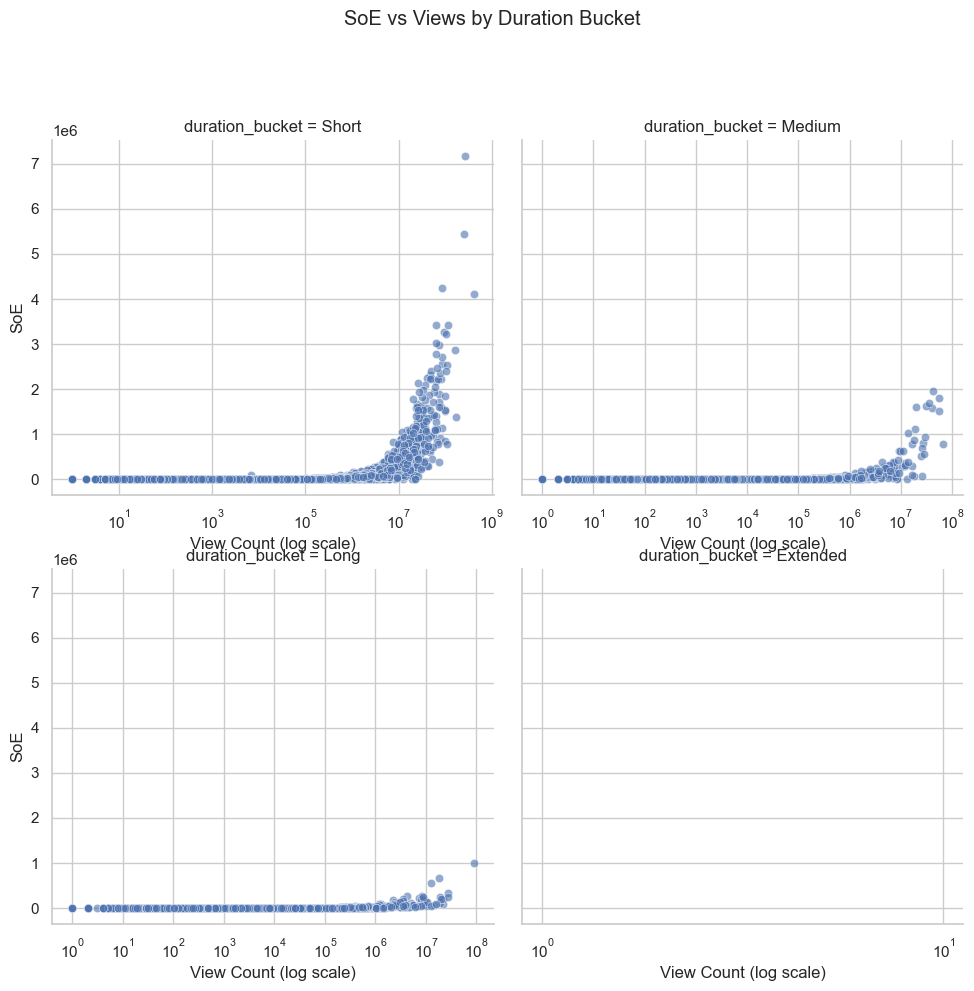

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# Ensure seaborn style
sns.set(style="whitegrid")

# Boxplot: SoE distribution per duration bucket
plt.figure(figsize=(10,6))
sns.boxplot(x="duration_bucket", y="SoE", data=df_video, order=["Short", "Medium", "Long", "Extended"])
plt.title("Distribution of SoE by Duration Bucket")
plt.xlabel("Duration Bucket")
plt.ylabel("SoE (Share of Engagement)")
plt.show()

# Scatter plots separated by duration bucket
g = sns.FacetGrid(df_video, col="duration_bucket", col_order=["Short", "Medium", "Long", "Extended"],
                  col_wrap=2, height=5, sharex=False, sharey=True)
g.map(sns.scatterplot, "viewCount", "SoE", alpha=0.6)

# Log scale for x-axis (views)
for ax in g.axes.flat:
    ax.set_xscale("log")
    ax.set_xlabel("View Count (log scale)")
    ax.set_ylabel("SoE")

plt.subplots_adjust(top=0.85)
g.fig.suptitle("SoE vs Views by Duration Bucket")
plt.show()


# 🔽 Downsizing Dataset using SoE

This section filters out videos with **low engagement** and keeps only the **top-performing videos** based on the **Strength of Engagement (SoE)** metric.

## ⚙️ Method
- A **cutoff percentile** is applied to keep only the top slice of videos.
- The cutoff is currently defined in code as:

```python
cutoff = df_videos["SoE"].quantile(0.9998)   # ⬅️ You can change this value here

```
Currently kept at **0.02 percent** for ease of computation, and **reduce computation time**


In [ ]:
cutoffs = (
    df_video.groupby("duration_bucket")["SoE"]
    .quantile(0.9998)
    .reset_index()
    .rename(columns={"SoE": "SoE_cutoff"})
)

df_video_merged = df_video.merge(cutoffs, on="duration_bucket", how="left")
df_top_videos = df_video_merged[df_video_merged["SoE"] >= df_video_merged["SoE_cutoff"]].copy()
df_top_comments = clean_comments[clean_comments["videoId"].isin(df_top_videos["videoId"])].copy()

summary = (
    df_top_videos.groupby("duration_bucket")
    .agg(
        total_videos=("videoId", "count"),
        avg_SoE=("SoE", "mean")
    )
    .reset_index()
)

print("Top videos per bucket:")
print(summary)

print(f"\nTotal comments kept: {len(df_top_comments)}")

# Debug check: ensure no inf

print(df_top_videos.columns)
print(df_top_comments.columns)

C:\Users\lixia\AppData\Local\Temp\ipykernel_7124\556784639.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df_video.groupby("duration_bucket")["SoE"]
C:\Users\lixia\AppData\Local\Temp\ipykernel_7124\556784639.py:13: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df_top_videos.groupby("duration_bucket")


Top videos per bucket:
  duration_bucket  total_videos     avg_SoE
0           Short            16  3515072.25
1          Medium             2  1876286.50
2            Long             1  1003700.00

Total comments kept: 214414
Index(['kind', 'videoId', 'publishedAt', 'channelId', 'title', 'description',
       'tags', 'defaultLanguage', 'defaultAudioLanguage', 'contentDuration',
       'viewCount', 'likeCount', 'favouriteCount', 'commentCount',
       'topicCategories', 'spam_count', 'AdjCommentCount', 'video_text',
       'categories', 'primary_category', 'duration_seconds', 'duration_bucket',
       'duration_safe', 'AdjViews', 'weighted_engagement', 'SoE',
       'SoE_cutoff'],
      dtype='object')
Index(['kind', 'commentId', 'channelId', 'videoId', 'authorId', 'textOriginal',
       'parentCommentId', 'likeCount', 'publishedAt', 'updatedAt', 'spam_rule',
       'repeated_across_videos', 'is_spam'],
      dtype='object')


# 🧠📊 Transformer (Sentiment Analysis)

This section runs **sentiment analysis** on video comments using **CardiffNLP’s RoBERTa model**:  

👉 Model used: [`twitter-roberta-base-sentiment`](https://huggingface.co/cardiffnlp/twitter-roberta-base-sentiment)  

## ⚙️ Method
- Uses **PyTorch** as the backend for deep learning computations.  
- Loads a **pretrained RoBERTa sentiment model** from Hugging Face.
- Tokenizes comments into model-readable format.
- Processes comments in **batches** (using GPU if available, else CPU).
- Predicts **sentiment labels** and their **probabilities**.

## 🏷️ Labels
- `0 = Negative`  
- `1 = Neutral`  
- `2 = Positive`  

## 📌 Purpose
- Helps classify the emotional tone of each comment.  
- Used later in analysis to link **viewer sentiment** with **video engagement**.  


In [ ]:
##SENTIMENT ANALYSIS
print("Loading model and tokenizer...\n")

task = "sentiment"
device = 0 if torch.cuda.is_available() else -1
print("Using device:", "GPU" if device == 0 else "CPU")
MODEL = f"cardiffnlp/twitter-roberta-base-{task}"
tokenizer = AutoTokenizer.from_pretrained(MODEL)
model = AutoModelForSequenceClassification.from_pretrained(MODEL)
model.to("cuda" if torch.cuda.is_available() else "cpu")
model.eval()

print("Test prompt:\n")
# -----------------------------
# Load model + tokenizer on GPU
# -----------------------------
#device = 0 if torch.cuda.is_available() else -1
#print("Using device:", "GPU" if device == 0 else "CPU")

# ====== Example: load your dataset (replace with your file) ======
# Let's assume you have a CSV with a 'textOriginal' column
df = df_top_comments.copy()
texts = df["textOriginal"].astype(str).tolist()

# ====== Dataset Class ======
class CommentDataset(Dataset):
    def __init__(self, texts, tokenizer, max_len=128):
        self.texts = texts
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = self.texts[idx]
        encoding = self.tokenizer(
            text,
            truncation=True,
            padding="max_length",
            max_length=self.max_len,
            return_tensors="pt"
        )
        return {key: val.squeeze(0) for key, val in encoding.items()}

# ====== DataLoader for batching ======
dataset = CommentDataset(texts, tokenizer)
dataloader = DataLoader(dataset, batch_size=32, shuffle=False)

# ====== Inference with probabilities ======
all_preds = []
all_probs = []

#device = "cuda" if torch.cuda.is_available() else "cpu"
start_time = time.time()  # start timer

with torch.no_grad():
    for i, batch in enumerate(tqdm(dataloader, desc="Processing"), 1):
        batch = {k: v.to(device) for k, v in batch.items()}
        outputs = model(**batch)
        probs = torch.softmax(outputs.logits, dim=-1)
        preds = torch.argmax(probs, dim=-1)

        all_preds.extend(preds.cpu().numpy())

        all_probs.extend(probs.cpu().numpy())

        # ETA logging every 100 batches
        #if i % 3000 == 0:
        #    elapsed = time.time() - start_time
        #    avg_time_per_batch = elapsed / i
        #    remaining_batches = len(dataloader) - i
        #    eta = remaining_batches * avg_time_per_batch
        #    eta_formatted = format_time(eta)
        #    print(f"[Batch {i}/{len(dataloader)}] ETA: {eta_formatted}")

# ====== Append results into original dataframe ======
df["prediction"] = all_preds
df["probability"] = [list(p) for p in all_probs]  # keep full probability vector

# ====== Save results ======
df.to_csv("sentiment_results.csv", index=False)
print("Saved sentiment_results.csv ✅")



Loading model and tokenizer...

Using device: GPU
Test prompt:



Processing: 100%|██████████| 6701/6701 [22:15<00:00,  5.02it/s]


Saved sentiment_results.csv ✅


# 🧠📊 Transformer (Relevancy Analysis)

This section measures how **relevant each comment is to its corresponding video** using a multilingual Transformer model.  

👉 Model used: [`paraphrase-multilingual-MiniLM-L12-v2`](https://huggingface.co/sentence-transformers/paraphrase-multilingual-MiniLM-L12-v2)  

## ⚙️ Method
- Uses **PyTorch** and **SentenceTransformers** from Hugging Face.  
- Loads **comment text** and **video text**, pairing each comment with its video.  
- Encodes both using a **sentence embedding model**.  
- Computes **cosine similarity** between embeddings → gives a *relevance score*.  
- Applies **two thresholds** for relevance detection:  
  - **Adaptive cutoff**: 70th percentile per video.  
  - **Global cutoff**: fixed at `0.6`.  

## 📌 Purpose
- Helps identify **which comments are contextually relevant** to the video content.  
- Reduces noise from off-topic or spammy comments.  
- Creates a filtered dataset for **downstream sentiment and engagement analysis**.  


In [ ]:
# ---------- 1) Load data ----------
df_read = pd.read_csv("sentiment_results.csv")
df_top_videos_read = pd.read_csv("videos_categorised.csv")
df_sentiment = df_read.merge(
    df_top_videos_read[["videoId", "video_text", "primary_category"]],
    on="videoId", how="left"
)

# ---------- 2) Dataset Class ----------
class VideoCommentDataset(Dataset):
    def __init__(self, df):
        self.comments = df["textOriginal"].tolist()
        self.videos = df["video_text"].tolist()

    def __len__(self):
        return len(self.comments)

    def __getitem__(self, idx):
        return self.comments[idx], self.videos[idx], idx

# ---------- 3) Setup ----------
device = "cuda" if torch.cuda.is_available() else "cpu"
MODEL_NAME = "sentence-transformers/paraphrase-multilingual-MiniLM-L12-v2"
model = SentenceTransformer(MODEL_NAME, device=device)

BATCH = 8
dataset = VideoCommentDataset(df_sentiment)
dataloader = DataLoader(dataset, batch_size=BATCH, shuffle=False)

# ---------- 4) Streaming similarity ----------
scores = torch.zeros(len(df_sentiment), dtype=torch.float32, device="cpu")

t0 = perf_counter()
with torch.no_grad():
    with tqdm(total=len(dataset), desc="Encode + similarity", unit="pair") as bar:
        for batch in dataloader:
            batch_c, batch_v, idxs = batch

            # Encode comment + video
            emb_c = model.encode(batch_c, batch_size=len(batch_c), convert_to_tensor=True,
                                 normalize_embeddings=True, show_progress_bar=False)
            emb_v = model.encode(batch_v, batch_size=len(batch_v), convert_to_tensor=True,
                                 normalize_embeddings=True, show_progress_bar=False)

            # Compute cosine similarity (dot product since normalized)
            sims_batch = (emb_c * emb_v).sum(dim=1)

            # Save results in correct positions
            scores[idxs] = sims_batch.cpu()

            bar.update(len(batch_c))

df_sentiment["relevance_score"] = scores.numpy()
print(f"[similarity] {(perf_counter()-t0):.2f}s")

# ---------- 5) Thresholding ----------
per_video_cutoff = df_sentiment.groupby("videoId")["relevance_score"].transform(lambda s: s.quantile(0.70))
df_sentiment["is_relevant_adaptive"] = df_sentiment["relevance_score"] >= per_video_cutoff

THRESHOLD = 0.6
df_sentiment["is_relevant"] = df_sentiment["relevance_score"] >= THRESHOLD

# ---------- 6) Save ----------
df_sentiment.to_csv("Sentiment_Relevancy.csv", index=False)
print("[done] Results saved to Sentiment_Relevancy.csv")


Encode + similarity: 100%|██████████| 214414/214414 [17:16<00:00, 206.89pair/s]


[similarity] 1036.35s
[done] Results saved to Sentiment_Relevancy.csv


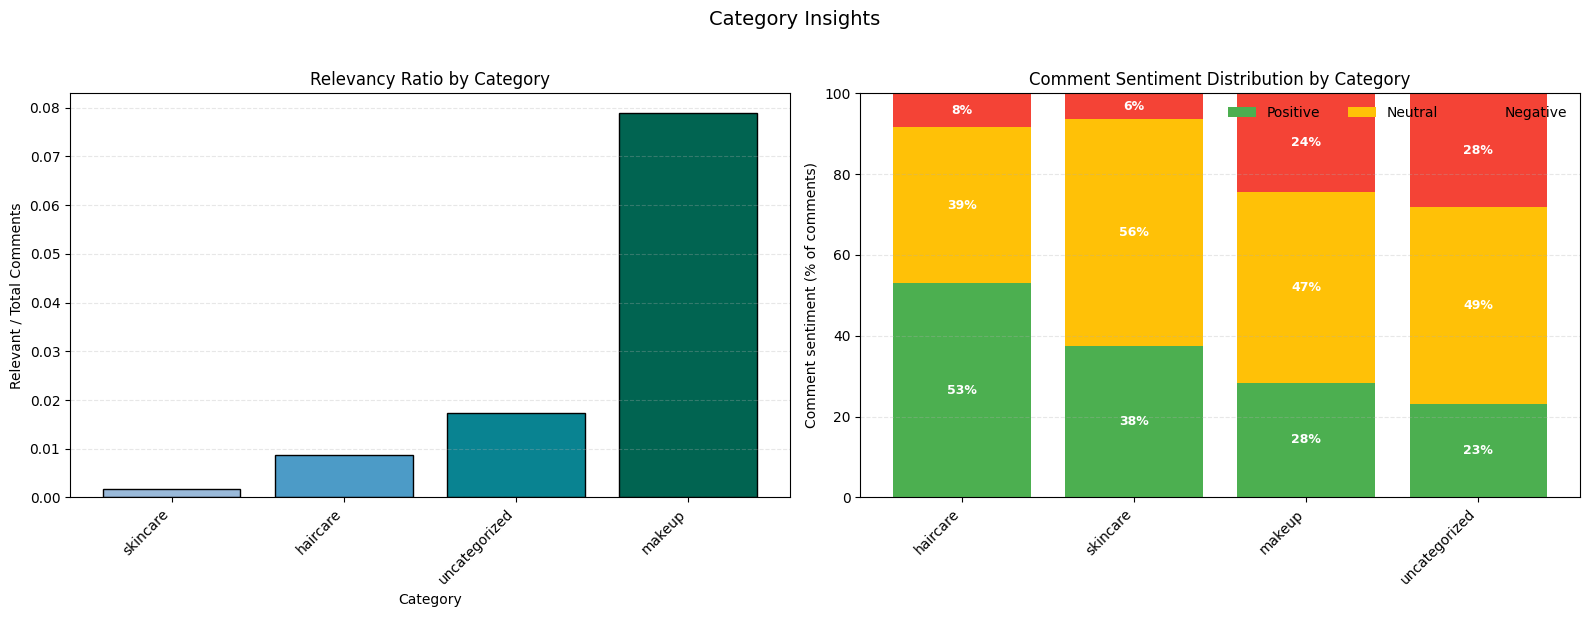

In [ ]:
# ---- Pandas display (show full text, no truncation) ----
pd.set_option("display.max_colwidth", None)   # no limit
pd.set_option("display.max_columns", None)    # show all columns
pd.set_option("display.width", None)          # don't force line breaks

# --------------------------
# Config / Paths
# --------------------------
DATA_DIR = r"C:\Users\lixia\Downloads\LOrealCompPrototype\LOrealCompPrototype"  # current working directory

sentiment_path = os.path.join(DATA_DIR, "Sentiment_Relevancy.csv")
videos_path    = os.path.join(DATA_DIR, "videos_categorised.csv")

df_sentiment = pd.read_csv(sentiment_path)
df_videos    = pd.read_csv(videos_path)

video_key     = "videoId"
soe_col       = "SoE"
category_col  = "primary_category"
relevant_col  = "is_relevant"
prob_col      = "probability"         # per-comment probability vector column
class_labels  = ["negative", "neutral", "positive"]  # order used by your model


# --------------------------
# Load data
# --------------------------
df = pd.read_csv(videos_path)
df_sentiment = pd.read_csv(sentiment_path)

# --------------------------
# Helpers
# --------------------------
def _to_bool(x):
    if pd.isna(x):
        return False
    if isinstance(x, (bool, np.bool_)):
        return bool(x)
    try:
        return float(x) != 0.0
    except Exception:
        return str(x).strip().lower() in {"true","t","yes","y","1","relevant"}

def parse_probs_cell(x):
    """
    Accepts:
      - list/np.ndarray of floats
      - string repr like "[np.float32(0.1), 0.2, 0.7]"
    Returns list[float] or None
    """
    if isinstance(x, (list, np.ndarray)):
        try:
            return [float(v) for v in x]
        except Exception:
            return None
    if isinstance(x, str):
        s = x.replace("np.float32(", "").replace(")", "")
        try:
            vals = ast.literal_eval(s)
            return [float(v) for v in vals]
        except Exception:
            return None
    return None

def argmax_label(p):
    if p is None or len(p) != len(class_labels):
        return None
    return class_labels[int(np.argmax(p))]

def parse_categories_cell(x):
    """
    Robustly parse the 'categories' column that may be:
      - list (['Makeup','Skincare'])
      - stringified list ("['Makeup', 'Skincare']")
      - delimited string ('Makeup|Skincare', 'Makeup, Skincare', etc.)
    Returns list[str].
    """
    if isinstance(x, list):
        return [str(v).strip() for v in x]
    if isinstance(x, str):
        s = x.strip()
        # Try list-like first
        try:
            val = ast.literal_eval(s)
            if isinstance(val, (list, tuple)):
                return [str(v).strip() for v in val]
        except Exception:
            pass
        # Fallback delimiters
        for sep in ['|', ',', ';', '/']:
            if sep in s:
                return [v.strip() for v in s.split(sep) if v.strip()]
        return [s] if s else []
    return []

# --------------------------
# Prepare relevance + filter
# --------------------------
# Parse multi-category column if present
has_categories_col = "categories" in df.columns
if has_categories_col:
    df["categories_list"] = df["categories"].apply(parse_categories_cell)
else:
    df["categories_list"] = [[] for _ in range(len(df))]

# Filter to videos with enough comments
df_filter = df[df["commentCount"] >= 0].copy()
valid_vids = set(df_filter[video_key])

# Restrict comments to valid vids and build relevance flag
com_top = df_sentiment[df_sentiment[video_key].isin(valid_vids)].copy()
com_top["_relevant_flag"] = com_top[relevant_col].map(_to_bool)

# Ensure per-comment probabilities and label exist (and split into columns)
if prob_col in com_top.columns:
    com_top["probs"] = com_top[prob_col].apply(parse_probs_cell)
else:
    com_top["probs"] = None

# Split probabilities into named columns following class_labels order
for name in ["negative", "neutral", "positive"]:
    com_top[f"prob_{name}"] = 0.0

def _extract_probs(row):
    p = row.get("probs", None)
    if p is None or len(p) != len(class_labels):
        return {f"prob_{lab}": 0.0 for lab in class_labels}, None
    d = {f"prob_{lab}": float(p[i]) for i, lab in enumerate(class_labels)}
    lbl = argmax_label(p)
    return d, lbl

_probs, _labels = [], []
for _, r in com_top.iterrows():
    d, lbl = _extract_probs(r)
    _probs.append(d)
    _labels.append(lbl if lbl is not None else "unknown")

_probs_df = pd.DataFrame(_probs, index=com_top.index)
com_top[_probs_df.columns] = _probs_df
com_top["sentiment_label"] = _labels

# per-video relevant counts
agg_rel = (
    com_top.groupby(video_key)["_relevant_flag"]
           .sum()
           .reset_index(name="relevant_comments")
)

# base video info + relevance ratio (include categories if present)
base_cols = [video_key, "title", category_col, "commentCount", soe_col]
if has_categories_col:
    base_cols.append("categories")
df_base = df_filter[base_cols].merge(agg_rel, on=video_key, how="left")
df_base["relevant_comments"] = df_base["relevant_comments"].fillna(0).astype(int)
df_base["relevance_ratio"] = df_base["relevant_comments"] / df_base["commentCount"].replace(0, np.nan)

# Keep parsed list for filtering
df_base = df_base.merge(df[[video_key, "categories_list"]], on=video_key, how="left")

# ==========================
# ==========================
# PLOTS (shown BEFORE the UI)
# Left: Weighted Relevancy Ratio by Category
# Right: Category-level sentiment % (stacked)
# ==========================

# ----- LEFT: Weighted Relevancy Ratio by Category -----
cat_group = df_base.groupby(category_col, dropna=False).agg(
    total_relevant=("relevant_comments", "sum"),
    total_comments=("commentCount", "sum")
).reset_index()
cat_group["weighted_relevance_ratio"] = (
    cat_group["total_relevant"] / cat_group["total_comments"].replace(0, np.nan)
).fillna(0.0)
cat_plot = cat_group.sort_values("weighted_relevance_ratio", ascending=True)

# ----- RIGHT: Category-level sentiment % (stacked) -----
# Build sentiment counts by category from com_top (filtered to valid_vids)
cat_counts = (
    com_top.groupby([category_col, "sentiment_label"])
           .size()
           .unstack(fill_value=0)
           .reindex(columns=class_labels, fill_value=0)
)
totals = cat_counts.sum(axis=1).replace(0, np.nan)
cat_pct = (
    cat_counts.div(totals, axis=0)
              .fillna(0.0)
              .rename(columns={
                  "positive": "pct_comments_positive",
                  "neutral":  "pct_comments_neutral",
                  "negative": "pct_comments_negative"
              })
              .reset_index()
)
# Sort by % positive, descending (like your Streamlit version)
cat_pct = cat_pct.sort_values("pct_comments_positive", ascending=False)

# Prepare arrays for stacked bars (in %)
cats = cat_pct[category_col].astype(str).tolist()
pos  = (cat_pct["pct_comments_positive"].values * 100)
neu  = (cat_pct["pct_comments_neutral"].values  * 100)
neg  = (cat_pct["pct_comments_negative"].values * 100)
x    = np.arange(len(cats))

# ----- Create side-by-side figure -----
fig, (axL, axR) = plt.subplots(1, 2, figsize=(16, 6))
fig.suptitle("Category Insights", y=1.02, fontsize=14)

# ---- Draw LEFT (weighted relevancy ratio as vertical bars) ----
xL = np.arange(len(cat_plot))
bars = axL.bar(
    xL,
    cat_plot["weighted_relevance_ratio"],
    edgecolor="black"
)

# Optional soft colormap
colors = plt.cm.PuBuGn(np.linspace(0.4, 0.9, len(cat_plot)))
for b, c in zip(bars, colors):
    b.set_facecolor(c)

axL.set_title("Relevancy Ratio by Category")
axL.set_xlabel("Category")
axL.set_ylabel("Relevant / Total Comments")
axL.set_xticks(xL)
axL.set_xticklabels(cat_plot[category_col].astype(str), rotation=45, ha="right")
axL.grid(axis="y", linestyle="--", alpha=0.3)

# ---- Draw RIGHT (stacked sentiment %) ----
p1 = axR.bar(x, pos, label="Positive", color="#4CAF50")
p2 = axR.bar(x, neu, bottom=pos, label="Neutral", color="#FFC107")
p3 = axR.bar(x, neg, bottom=pos+neu, label="Negative", color="#F44336")

def annotate_stack(ax, bars, values, bottoms=None):
    for bar, val, bot in zip(
        bars, values, bottoms if bottoms is not None else np.zeros_like(values)
    ):
        if val <= 0:
            continue
        ax.text(
            bar.get_x() + bar.get_width()/2,
            bot + val/2,
            f"{val:.0f}%",
            ha="center", va="center",
            fontsize=9, color="white", weight="bold"
        )

annotate_stack(axR, p1, pos)
annotate_stack(axR, p2, neu, bottoms=pos)
annotate_stack(axR, p3, neg, bottoms=pos+neu)

axR.set_xticks(x)
axR.set_xticklabels(cats, rotation=45, ha="right")
axR.set_ylabel("Comment sentiment (% of comments)")
axR.set_title("Comment Sentiment Distribution by Category")
axR.set_ylim(0, 100)
axR.legend(ncol=3, frameon=False)
axR.grid(axis="y", linestyle="--", alpha=0.3)

plt.tight_layout()
plt.show()


# --------------------------
# Widgets
# --------------------------
# Category options from BOTH primary_category and categories_list
all_primary = set(df_base[category_col].dropna().astype(str).unique())
all_from_lists = set(cat for lst in df["categories_list"] for cat in lst)
all_cats = sorted(all_primary.union(all_from_lists))

cat_options = [""] + all_cats
w_category  = widgets.Dropdown(options=cat_options, description='Category:', layout=widgets.Layout(width="60%"))
w_video     = widgets.Dropdown(options=[""], description='Video:', layout=widgets.Layout(width="60%"))
w_reset     = widgets.Button(description="Reset", button_style="warning")
out_top10   = widgets.Output()
out_comments= widgets.Output()

def label_row(row):
    t = str(row.get("title", ""))
    vid = str(row.get(video_key, ""))[:8]
    return f"{t}  ({vid})" if t else vid

def on_reset_clicked(_):
    w_category.value = ""
    w_video.options = [""]
    w_video.value = ""
    out_top10.clear_output()
    out_comments.clear_output()

def on_category_change(change):
    if change["name"] == "value":
        out_top10.clear_output()
        out_comments.clear_output()
        sel_cat = change["new"]
        if not sel_cat:
            w_video.options = [""]
            w_video.value = ""
            return

        # --- FILTER: match primary_category OR membership in categories_list
        mask = (
            df_base[category_col].astype(str).eq(sel_cat)
            | df_base["categories_list"].apply(lambda lst: sel_cat in lst if isinstance(lst, list) else False)
        )
        vids_in_cat = set(df_base.loc[mask, video_key])

        # sentiment ratios within selected category (per video)
        sent_tbl = (
            com_top[com_top[video_key].isin(vids_in_cat)]
            .groupby([video_key, "sentiment_label"])
            .size()
            .unstack(fill_value=0)
            .reindex(columns=class_labels, fill_value=0)
        )
        denom = sent_tbl.sum(axis=1).replace(0, np.nan)
        sent_ratio = (
            sent_tbl.div(denom, axis=0).fillna(0.0)
                    .rename(columns={
                        "positive": "ratio_positive",
                        "neutral":  "ratio_neutral",
                        "negative": "ratio_negative"
                    })
                    .reset_index()
        )

        # Merge; include 'categories' column for display if present
        display_cols = [video_key, "title", "commentCount", "relevance_ratio",
                        "ratio_positive", "ratio_neutral", "ratio_negative"]
        base_sel_cols = [video_key, "title", category_col, "commentCount", "relevance_ratio"]
        if "categories" in df_base.columns:
            base_sel_cols.append("categories")
            display_cols.insert(2, "categories")  # after title

        df_cat = (
            df_base[mask][base_sel_cols]
            .merge(sent_ratio, on=video_key, how="left")
            .fillna({"ratio_positive": 0.0, "ratio_neutral": 0.0, "ratio_negative": 0.0})
        )

        top10 = (
            df_cat.sort_values("relevance_ratio", ascending=False)
                  .head(10)
                  .reset_index(drop=True)
        )

        with out_top10:
            df_show = pd.DataFrame(top10[display_cols]).copy()
            styler = df_show.style.set_properties(
                subset=[c for c in ["title", "categories"] if c in df_show.columns],
                **{"white-space": "normal"}  # enable wrapping
            ).set_table_styles([
                {"selector": "th, td", "props": [("text-align", "left"), ("vertical-align", "top")]}
            ])
            display(styler)

        # build video dropdown
        if len(top10):
            label_map = {label_row(r): r[video_key] for _, r in top10.iterrows()}
            w_video.options = [""] + list(label_map.keys())
            # stash mapping on the widget for retrieval
            w_video._label_map = label_map
            w_video.value = ""
        else:
            w_video.options = [""]
            w_video.value = ""

def on_video_change(change):
    if change["name"] == "value":
        out_comments.clear_output()
        lab = change["new"]
        if not lab:
            return

        sel_vid = w_video._label_map.get(lab)
        # Relevant-only comments for selected video
        rel_only = com_top[(com_top[video_key] == sel_vid) & (com_top["_relevant_flag"])].copy()

        # Normalize commentId
        if "commentid" not in rel_only.columns and "commentId" in rel_only.columns:
            rel_only = rel_only.rename(columns={"commentId": "commentid"})

        # Exact columns to show (includes per-comment probs + label)
        wanted = [
            "videoId", "commentid", "textOriginal", "is_relevant", "sentiment_label"
        ]
        keep = [c for c in wanted if c in rel_only.columns]

        with out_comments:
            if keep:
                df_show = rel_only[keep].reset_index(drop=True).copy()
                # wrap long comment text
                wrap_cols = [c for c in ["textOriginal", "title"] if c in df_show.columns]
                styler = df_show.style.set_properties(
                    subset=wrap_cols,
                    **{"white-space": "normal"}
                ).set_table_styles([
                    {"selector": "th, td", "props": [("text-align", "left"), ("vertical-align", "top")]}
                ])
                display(styler)
            else:
                display(pd.DataFrame({"info": ["Requested columns not found in data."]}))


# Hook up events
w_reset.on_click(on_reset_clicked)
w_category.observe(on_category_change, names="value")
w_video.observe(on_video_change, names="value")

# Render UI
ui = widgets.VBox([
    widgets.HBox([w_category, w_reset]),
    widgets.HTML("<b>Top 10 videos (by relevance ratio) with sentiment ratios</b>"),
    out_top10,
    widgets.HTML("<b>Relevant comments only</b>"),
    w_video,
    out_comments
])

display(ui)